In [1]:
import pandas as pd
import datetime
import shapely
import sys
import boto3
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import geoplot


from IPython.display import Image
from shapely.ops import transform, cascaded_union
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from time import sleep
from io import BytesIO,StringIO

## We connect to AWS S3 Bucket

In [2]:
def connect_to_aws():
    counter = 1
    while True:
        try:
            s3 = boto3.resource('s3')
            s3c = boto3.client('s3')
            print("[INFO] Succesfully mounted S3 bucket ")
            return s3,s3c

        except Exception as e:
            #try to connect 10 times, other wise stops program
            if counter > 1:
                print('[ERROR] {}. Unable to stablish conection with S3 bucket'.format(e))
                os._exit(os.EX_OK)
            else:
                print('[ERROR] {} FOUND: retrying S3 client connection'.format(e))
                sleep(5)
                counter += 1

In [3]:
bucket="sbb-un-real"
s3,s3c=connect_to_aws()

[INFO] Succesfully mounted S3 bucket 


## We import the data

In [4]:
def load_data_pd(bucket,sep,key,s3,s3c):
    counter = 1
    while True:
        try:
            my_bucket = s3.Bucket(bucket)
            obj = s3c.get_object(Bucket=bucket, Key=key)
            df=pd.read_csv(BytesIO(obj['Body'].read()),sep=sep)
            print("[INFO] succesfully loaded {}".format(key))
            return df
        except Exception as e:
            #try to connect 10 times, other wise stops program
            if counter > 5:
                print('[ERROR] {}. Unable to stablish conection with S3 bucket'.format(e))
                sys.exit()
            else:
                print('[ERROR] {} FOUND: retrying S3 client connection'.format(e))
                sleep(5)
                counter += 1
def load_data_gpd(bucket,key):
    counter = 1
    while True:
        try:
            df=gpd.read_file('s3://'+bucket+'/'+key)
            print("[INFO] succesfully loaded {}".format(key))
            return df
        except Exception as e:
            #try to connect 10 times, other wise stops program
            if counter > 5:
                print('[ERROR] {}. Unable to stablish conection with S3 bucket'.format(e))
                sys.exit()
            else:
                print('[ERROR] {} FOUND: retrying S3 client connection'.format(e))
                sleep(5)
                counter += 1

In [ ]:
stations=load_data_pd(bucket,';','data/geo_spatial/dienststellen-gemass-opentransportdataswiss.csv',s3,s3c)
main_stations=load_data_pd(bucket,',','data/scrapped_data/main_stations_scrapper.csv',s3,s3c)
swiss_post_points=load_data_pd(bucket,';','data/geo_spatial/zugangspunkte-post.csv',s3,s3c)
otonomo_trips=load_data_pd(bucket,',',
        'data/car/reports_1016704_part-00000-1d7ef93e-159f-406a-9a38-d3cc809c234f-c000_20211130T120000Z.csv',s3,s3c)
residential_areas=load_data_pd(bucket,';','data/residential_areas/GWS2020_HA.csv',s3,s3c)
migros_points=load_data_pd(bucket,',','data/scrapped_data_migros/stores_scrapper.csv',s3,s3c)
swiss_boundary = load_data_gpd(bucket,'data/switzerland_shapefile/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp')


[INFO] succesfully loaded data/geo_spatial/dienststellen-gemass-opentransportdataswiss.csv
[INFO] succesfully loaded data/scrapped_data/main_stations_scrapper.csv


## Now we filter the points that are main stations

In [6]:
def erase_last_digit(int_):
    if int_>9:
        list_ints=[a for a in str(int_)[:-1]]
        joined_str=''.join(list_ints)
        return int(joined_str)
    else:
        return int_
def take_first_name(name):
    if 'Limmattal' in name:
        return 'Limmattal'
    elif '/' in name: 
        return name.split('/')[0]
    elif '-' in name: 
        return name.split('-')[0]
    elif ' ' in name: 
        return name.split(' ')[0]
    elif 'Genève' in name:
        return 'Genf'
    else:
        return name

In [7]:
#defining filtering criteria based on scraped data 
keys1=['Content-Type: text/plain; charset=utf-8\n','Short_name']
keys2=['Short_id','Short_name']
main_stations['Short_id']=main_stations.Station_id.map(erase_last_digit)
main_stations['Short_name']=main_stations.Name.map(take_first_name)
stations['Short_name']=stations['Stop name'].map(take_first_name)

i1 = stations.set_index(keys1).index
i2 = main_stations.set_index(keys2).index

AttributeError: 'DataFrame' object has no attribute 'Station_id'

In [ ]:

#we take only the stations that are service points for freight.
service_points=stations[i1.isin(i2)].loc[(stations[i1.isin(i2)].IS_BEDIENPUNKT==1) & (stations[i1.isin(i2)]['CANTON NAME'].notna())]
service_points['latitude']=service_points.Geopos.str.split(',').map(lambda x: float(x[0]))
service_points['longitude']=service_points.Geopos.str.split(',').map(lambda x: float(x[1]))
geo_service_points = gpd.GeoDataFrame(service_points, geometry=gpd.points_from_xy(service_points.longitude,
                                                                                  service_points.latitude))
#we filter the points for swiss post
#dropping nans 
swiss_post_points = swiss_post_points[swiss_post_points.geopoint.notna()]
swiss_post_points['latitude']=swiss_post_points.geopoint.str.split(',').map(lambda x: float(x[0]))
swiss_post_points['longitude']=swiss_post_points.geopoint.str.split(',').map(lambda x: float(x[1]))
geo_swisspost_points = gpd.GeoDataFrame(swiss_post_points, geometry=gpd.points_from_xy(swiss_post_points.longitude,
                                                                                  swiss_post_points.latitude))
#we filter the points for otonomo data  
otonomo_trips
geo_otonomo_starting_points = gpd.GeoDataFrame(otonomo_trips, geometry=gpd.points_from_xy(otonomo_trips.location__longitude__start,
                                                                                  otonomo_trips.location__latitude__start))
geo_otonomo_finishing_points = gpd.GeoDataFrame(otonomo_trips, geometry=gpd.points_from_xy(otonomo_trips.location__longitude__end,
                                                                                  otonomo_trips.location__latitude__end))
#we filter the points for residential areas 
geo_residential_points= gpd.GeoDataFrame(residential_areas, geometry=gpd.points_from_xy(residential_areas.E_KOORD,
                                                                                  residential_areas.N_KOORD))


## We transform the points from the swiss LV95 projection into the World Geodetic System 

In [ ]:
lv95 = pyproj.CRS('EPSG:2056')
wgs84 = pyproj.CRS('EPSG:4326')
project = pyproj.Transformer.from_crs(lv95, wgs84, 
                                          always_xy=True).transform
swiss_boundary['geometry']=swiss_boundary.geometry.map(lambda x: transform(project, x))
## we convert the residential areas
geo_residential_points['geometry']=geo_residential_points.geometry.map(lambda x: transform(project, x))

## We display the computed service stations

In [ ]:
fig=px.scatter_geo(service_points, lat="latitude",lon='longitude',color="CANTON NAME",
                     hover_name="Stop name",scope='europe')

fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
swiss_boundary.plot(ax=ax, color='teal')
geo_service_points.plot(ax=ax, markersize=17.5, color='orange')
ax.axis('off')
plt.axis('equal')
plt.show()

## Then, we have recovered only the stations in the main freight roads
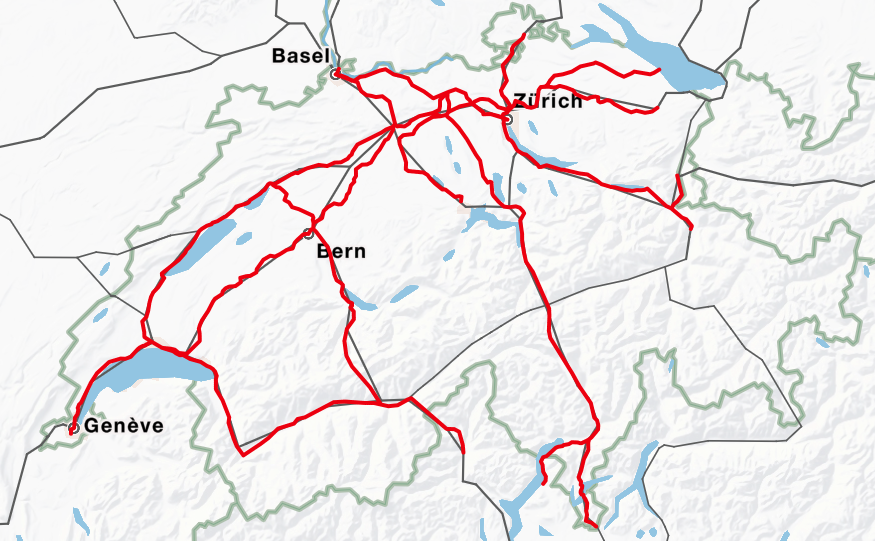

## We concatenate all kantons into one single boundary

In [ ]:
entire_swiss_shape=cascaded_union(swiss_boundary.geometry)
voronoi_centers = points_to_coords(geo_service_points.geometry)

### Now we compute the Voronoi Regions 

In [ ]:
# Calculate Voronoi Regions
poly_shapes, poly_to_pt_assignments = voronoi_regions_from_coords(voronoi_centers, entire_swiss_shape)

In [ ]:
#now we plot them 
fig, ax = plt.subplots(figsize=(20,14))
plot_voronoi_polys_with_points_in_area(ax, entire_swiss_shape, poly_shapes,voronoi_centers, poly_to_pt_assignments,
 voronoi_and_points_cmap='tab20c',
 points_markersize=20)
ax.set_title('Swiss freight stations  — Voronoi Regions')
ax.axis('off')
plt.tight_layout()
plt.show()

## Next we check with respec to the swiss post service points 

In [ ]:
#now we plot them 
fig, ax = plt.subplots(figsize=(20,14))
plot_voronoi_polys_with_points_in_area(ax, entire_swiss_shape, poly_shapes,voronoi_centers, poly_to_pt_assignments,
 voronoi_and_points_cmap='tab20c',
 points_markersize=20)
geo_swisspost_points.plot(ax=ax, markersize=4.5, color='orange')
ax.set_title('Swiss freight stations  — Voronoi Regions')
ax.axis('off')
plt.tight_layout()
plt.show()

## Now let's check with respecto trips data

In [ ]:
#now we plot them 
fig, ax = plt.subplots(figsize=(20,14))
plot_voronoi_polys_with_points_in_area(ax, entire_swiss_shape, poly_shapes,voronoi_centers, poly_to_pt_assignments,
 voronoi_and_points_cmap='tab20c',
 points_markersize=20)
geo_otonomo_starting_points.plot(ax=ax, markersize=4.5, color='orange')
ax.set_title('Otonomo Swiss trips starting points  — Voronoi Regions')
ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#now we plot them 
fig, ax = plt.subplots(figsize=(20,14))
plot_voronoi_polys_with_points_in_area(ax, entire_swiss_shape, poly_shapes,voronoi_centers, poly_to_pt_assignments,
 voronoi_and_points_cmap='tab20c',
 points_markersize=20)
geo_otonomo_finishing_points.plot(ax=ax, markersize=4.5, color='orange')
ax.set_title('Otonomo Swiss trips starting points  — Voronoi Regions')
ax.axis('off')
plt.tight_layout()
plt.show()

## Now we check the residential zones 

In [ ]:
#now we plot them 
fig, ax = plt.subplots(figsize=(20,14))
plot_voronoi_polys_with_points_in_area(ax, entire_swiss_shape, poly_shapes,voronoi_centers, poly_to_pt_assignments,
 voronoi_and_points_cmap='tab20c',
 points_markersize=20)
geo_residential_points.plot(ax=ax, markersize=1.5, alpha=0.1, color='orange')
ax.set_title('Otonomo Swiss trips starting points  — Voronoi Regions')
ax.axis('off')
plt.tight_layout()
plt.show()

## Finally we create a heat map based on all the locations

In [ ]:
#first we convert the data to 
voronoi_regions_data={'center_id':[], 'geometry':[],'coverage':[]}
for i in range(max(poly_shapes.keys())):
    voronoi_regions_data['center_id'].append(poly_to_pt_assignments[i][0])
    voronoi_regions_data['geometry'].append(poly_shapes[i])
    voronoi_regions_data['coverage'].append(geo_residential_points.geometry.within(poly_shapes[i]).sum())
        
swiss_voronoi = gpd.GeoDataFrame(voronoi_regions_data, crs="EPSG:4326")
swiss_voronoi

In [ ]:
fig = px.choropleth_mapbox(swiss_voronoi, geojson=swiss_voronoi, locations=swiss_voronoi.index, color='coverage',
                           color_continuous_scale="hot",
                           range_color=(0, swiss_voronoi.coverage.max()),
                           mapbox_style="carto-positron",
                           zoom=7, center = {"lat": 46.884516, "lon":  8.073475},
                           opacity=0.5,
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


,",Station_id,Name"
0,"0,21360,Aarau GB"
1,"1,44040,Aarberg"
2,"2,22244,Affoltern am Albis"
3,"3,10355,Allaman"
4,"4,51136,Altdorf"
...,...
303,"303,30395,Zürich Mülligen"
304,"304,35071,Zürich RB Limmattal"
305,"305,35469,Zürich RB Limmattal Wagenrep."
306,"306,30049,Zürich Tiefenbrunnen"
